In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


##Getting the Helper Functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-05 18:02:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-05 18:02:37 (125 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
#import functions from helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2023-08-05 18:02:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.128, 142.251.172.128, 108.177.112.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   146MB/s    in 12s     

2023-08-05 18:02:49 (131 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [ ]:
train_dir = "/content/101_food_classes_10_percent/train"
test_dir = "/content/101_food_classes_10_percent/test"

In [ ]:
walk_through_dir("/content/101_food_classes_10_percent")

There are 2 directories and 0 images in '/content/101_food_classes_10_percent'.
There are 101 directories and 0 images in '/content/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/strawberry_shortcake'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/deviled_eggs'.
There are 0 directories and 250 i

In [ ]:
#Setup the data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # dont shuffle the test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


STEPS:
 - create a ModelCheckpoint callback
 - create a data augmentation layer to build data augmentation right into the model
 - Build a headless (no top layers) Functional EfficientNetB0 backboned-model(create a very own output layer)
 - Compile the model
 - Feature extract for 5 full passes(5 epochs on the train dataset and validate on 15% of the test data to save the epoch time)


In [ ]:
#create a checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)
#'Save_best_only=True' save the epoch with the highest validation_accuracy
#'save_weights_only=True' save the weights only but if its set as False it saves the whole model which takes time

In [ ]:
#create data augmentation layer to incorprate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescale(1/255.)#Rescale inputs of images to between 0&1, required for models like ResNet50 but its already built in EffiecientNetB0
],name="data_augmentation")

INPUTS --> DATA AUGMENTATION --> EFFICIENTNETB0 MODEL --> GLOBALAVGPOOL2D --> OUTPUTS

In [ ]:
#setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False #this will freeze all the patterns that the EfficientNetB0 has learned

#setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs) #augment images(only happens during training phase)
x = base_model(x,training=False) #put the base model in inference mode so weights whichneed to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name = "gloabal_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gloabal_avg_pool_layer (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
#compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=(checkpoint_callback))

Epoch 1/5
237/237 [==============================] - 545s 2s/step - loss: 3.3728 - accuracy: 0.2737 - val_loss: 2.3648 - val_accuracy: 0.5132
Epoch 2/5
237/237 [==============================] - 575s 2s/step - loss: 2.2040 - accuracy: 0.4948 - val_loss: 1.9320 - val_accuracy: 0.5519
Epoch 3/5
237/237 [==============================] - 576s 2s/step - loss: 1.8266 - accuracy: 0.5589 - val_loss: 1.7841 - val_accuracy: 0.5667
Epoch 4/5
237/237 [==============================] - 600s 3s/step - loss: 1.6034 - accuracy: 0.6135 - val_loss: 1.7123 - val_accuracy: 0.5694
Epoch 5/5
237/237 [==============================] - 588s 2s/step - loss: 1.4475 - accuracy: 0.6463 - val_loss: 1.7088 - val_accuracy: 0.5599


In [ ]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 1172s 1s/step - loss: 1.5837 - accuracy: 0.5847


[1.5836917161941528, 0.5847128629684448]

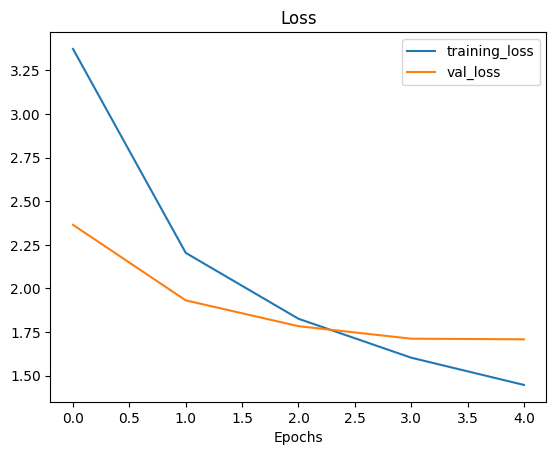

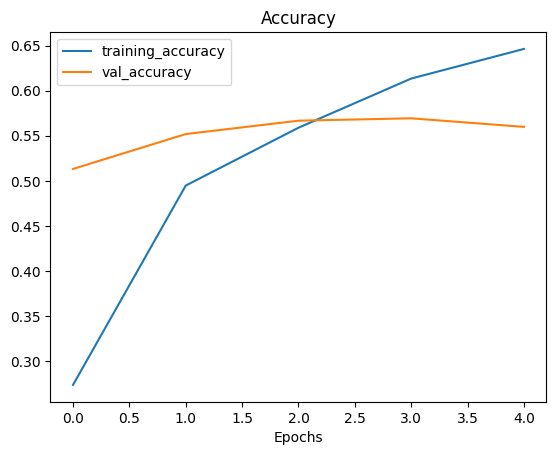

In [ ]:
plot_loss_curves(history_all_classes_10_percent)
# The validation loss must follow the training loss ideally for a good model
# If the training loss is decreasing and val loss is not following it,
# then it indicates overfitting.

##Fine-tuning

In [ ]:
#unfreeze all of the layers in the base model
base_model.trainable = True

#Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
#Recompile model with lower learning rate(its typically best practise to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
#what layers in the model are-trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
gloabal_avg_pool_layer True
output_layer True


In [ ]:
#check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
#Fine tune for five more epoch
fine_tune_epochs = 10 # model has already done 5 epochs(feature extraction), this is the total no of epochs we are after(5+5=10)

#Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 589s 2s/step - loss: 1.2099 - accuracy: 0.6853 - val_loss: 1.6499 - val_accuracy: 0.5651
Epoch 6/10
237/237 [==============================] - 589s 2s/step - loss: 1.0971 - accuracy: 0.7086 - val_loss: 1.6625 - val_accuracy: 0.5657
Epoch 7/10
237/237 [==============================] - ETA: 0s - loss: 1.0130 - accuracy: 0.7265

In [ ]:
#evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

In [ ]:
#compare the hostories of feature extraction model with fine-tuning
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

##Saving and loading the model

In [ ]:
#Save the fine tuning model
#model.save("drive/MyDrive/Tensorflow/101_food_classes_10_percent_saved_big_dog_model", save_format='tf')

In [ ]:
#Load and evaluate saved model
#loaded_model = tf.saved_model.load("drive/MyDrive/Tensorflow/101_food_classes_10_percent_saved_big_dog_model")


In [ ]:
#Evaluate loaded model and compare the performance to pre-saved model
#loaded_model_results = loaded_model.evaluate(test_data)
#laoded_model_results

##Evaluating the performance of th big dog model across all the different classes

In [ ]:
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
#Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
#Evaluate the loaded model (The one we just downloaded on the test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

##Making predictions with our trained model

In [ ]:
#make predictions with model
preds_probs = model.predict(test_data, verbose=1) #set verobosity to see how long is left


In [ ]:
len(preds_probs)

In [ ]:
#whats the shape of the predictions
preds_probs.shape

In [ ]:
#Lets see what the first ten predictions look like
preds_probs[:10]

In [ ]:
#What does the first prediction probability array looks like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

**Note:**Our model outputs a prediction probability array(with N number of variables, where N is the number of classes) for each sample passes to the predict method.

In [ ]:
#we get one prediction probability per class(in our case there is 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What predictions probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability for the sample 0: {preds_probs[0].argmax()}")

In [ ]:
#Get the predct classes of each label
pred_classes = preds_probs.argmax(axis = 1)

#how do they look
pred_classes[:10]

In [ ]:
#How many pred classes do we have
len(pred_classes)

Now we get a predictions array of all of our model's predictions, to evaluate them we need to compare them to the origibal test dataset labels

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) #currently test labels look like: [0,0,0,1.....0,0], we wnat the the index values where the "1" occurs
y_labels[:10] #look at the first 10

##Evaluating our model's predictions
One way to check our model's predictions array is in the same order as our test labels array is to find the accuracy score

In [ ]:
results_downloaded_model

In [ ]:
#using skikit-learn accuracy
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)
sklearn_accuracy

In [ ]:
  #Does this metric come close to our model's evaluate results
  import numpy as np
  np.isclose(results_downloaded_model[1], sklearn_accuracy)

##Making a confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
#Get the list of class names
class_names = test_data.class_names
class_names[:10]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
#we need to make some changes to the make_confusion_matrix function
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [ ]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

##Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

In [ ]:
#Get the dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict = True)
classification_report_dict

In [ ]:
#create empty dictionary
class_f1_scores = {}
#Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": #stop once we get to accuracy key
    break
  else:
    #Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

In [ ]:
#Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1_scores": list(class_f1_scores.values())}).sort_values("f1_scores", ascending=False)

In [ ]:
f1_scores